In [1]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

In [4]:
update = False

# Future = 10

In [5]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 20
dense_layers = 1
dense_neurons = 20
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,7)]
i=0
for iteration in iteration_list:
    for model_type in model_list: 
        model_num = iteration
        model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
        result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
        result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
        time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
        result = pd.concat([result, time_steps], axis=1)
        result['iteration'] = iteration
        result['num_layers'] = num_layers
        result['num_neurons'] = num_neurons
        result['dense_layers'] = dense_layers
        result['dense_neurons'] = dense_neurons        
        result['model_type'] = model_type
        if not i:
            result_reshape = result
        else:
            result_reshape = pd.concat([result_reshape, result], axis=0)
        i += 1

In [6]:
result_reshape[(result_reshape['step']=='mean')].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,num_layers,num_neurons,dense_layers,dense_neurons,model_type
10,0.642958,0.799249,0.889799,0.777336,8.823923,7.729619,5.031883,7.195142,mean,6,1,20,1,20,datt_seq2seq_gru
10,0.656708,0.766715,0.874986,0.766137,8.628254,8.307692,5.320105,7.418684,mean,5,1,20,1,20,datt_seq2seq_gru
10,0.631919,0.780723,0.883195,0.765279,8.976211,8.100767,5.132404,7.403127,mean,3,1,20,1,20,datt_seq2seq_gru
10,0.597279,0.808816,0.854256,0.753450,9.429545,7.558916,5.730935,7.573132,mean,4,1,20,1,20,att_seq2seq_gru
10,0.623861,0.758407,0.874762,0.752343,8.997721,8.438185,5.305946,7.580617,mean,1,1,20,1,20,datt_seq2seq_gru
10,0.630075,0.801419,0.816230,0.749242,8.998404,7.723742,6.358559,7.693568,mean,1,1,20,1,20,att_seq2seq_gru
10,0.611911,0.754147,0.857682,0.741247,9.243828,8.605473,5.673054,7.840785,mean,3,1,20,1,20,att_seq2seq_gru
10,0.639859,0.746132,0.837655,0.741215,8.909532,8.606851,6.034024,7.850135,mean,5,1,20,1,20,att_seq2seq_gru
10,0.597818,0.755336,0.856346,0.736500,9.338523,8.528579,5.702040,7.856381,mean,4,1,20,1,20,datt_seq2seq_gru
10,0.571688,0.758237,0.825062,0.718329,9.656901,8.461236,6.312900,8.143679,mean,1,1,20,1,20,seq2seq_gru


## according to steps

R2 results


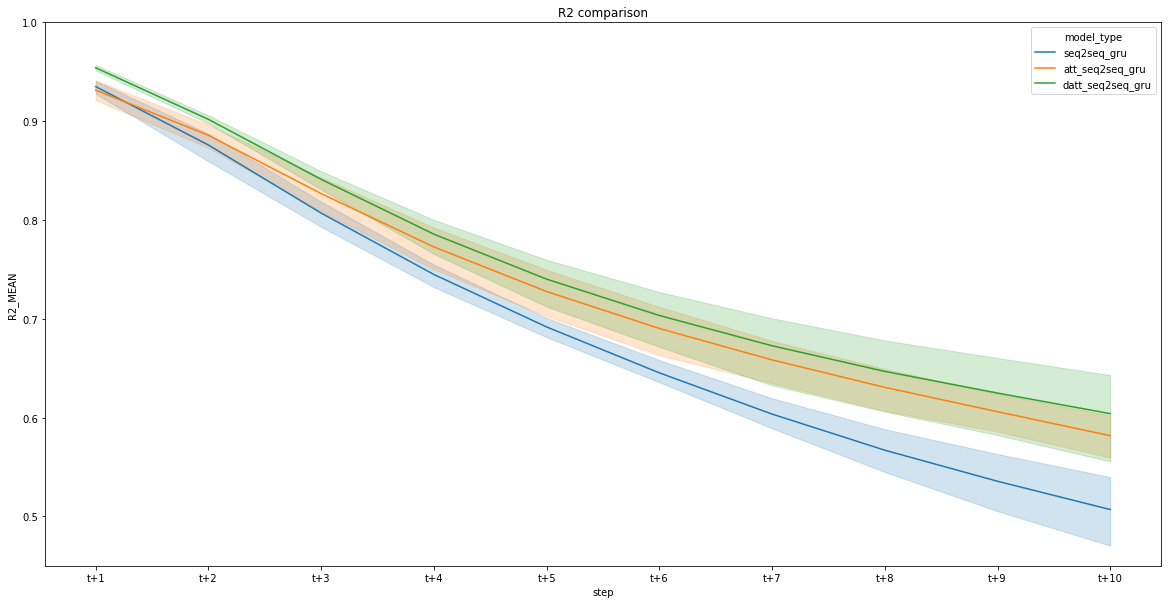

NRMSE results


<Figure size 432x288 with 0 Axes>

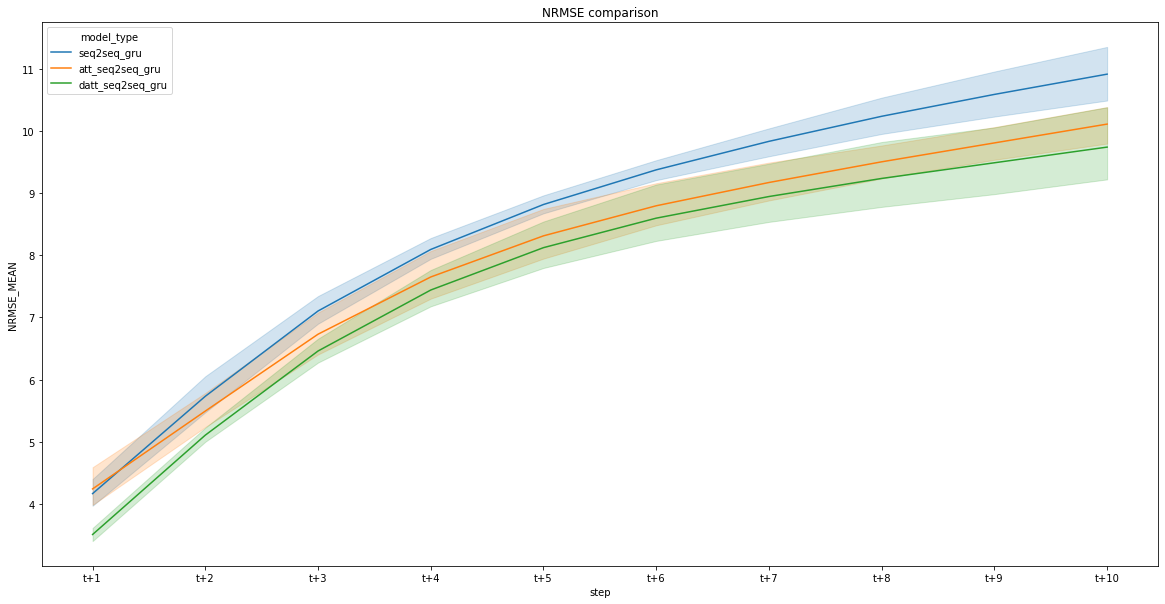

<Figure size 432x288 with 0 Axes>

In [7]:
data = result_reshape

plot_var = ['R2_MEAN']

print("R2 results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']!='mean'].reset_index(drop=True)
    sns.lineplot(x='step', y=var, hue='model_type', markers=True, data=plot_data)
    
    plt.ylim(0.45, 1.0)
    plt.title(f"R2 comparison")
    
figure_name = f'figure_4_model_comparison_{model_name}_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()


plot_var = ['NRMSE_MEAN']

print("NRMSE results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']!='mean'].reset_index(drop=True)
    sns.lineplot(x='step', y=var, hue='model_type', markers=True, data=plot_data)
    
    # plt.ylim(0.45, 1.0)
    plt.title(f"NRMSE comparison")
    
figure_name = f'figure_4_model_comparison_{model_name}_nrmse'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

# data = result_reshape

# plot_var = ['NRMSE_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2']
# att_type = 'linear'

# print("NRMSE results")
# plt.figure(figsize=(future_size*2,len(plot_var)*10))
# for i, var in enumerate(plot_var):
#     plt.subplot(len(plot_var), 1, i+1)
#     plot_data = data[data['att_type']==att_type]
#     sns.boxplot(x='step', y=var, hue='delta', data=plot_data, notch=False, showfliers = False)
#     # plt.ylim(-0.01, 0.3)
#     plt.title(f"attention type = {att_type}")
    
# figure_name = f'delta_comparison_linear_future_{future_size}_nrmse'
# if not exists(f'./figure/{figure_name}.png') or update:
#     savefile(_, './figure', figure_name, 'figure')
    
# plt.show()
# plt.tight_layout()

## Dual attention

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 40, 20),     1740        ['input_1[0][0]']                
                                 (None, 20)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 10, 20)       0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 20)       2520        ['repeat_vector[0][0]',      

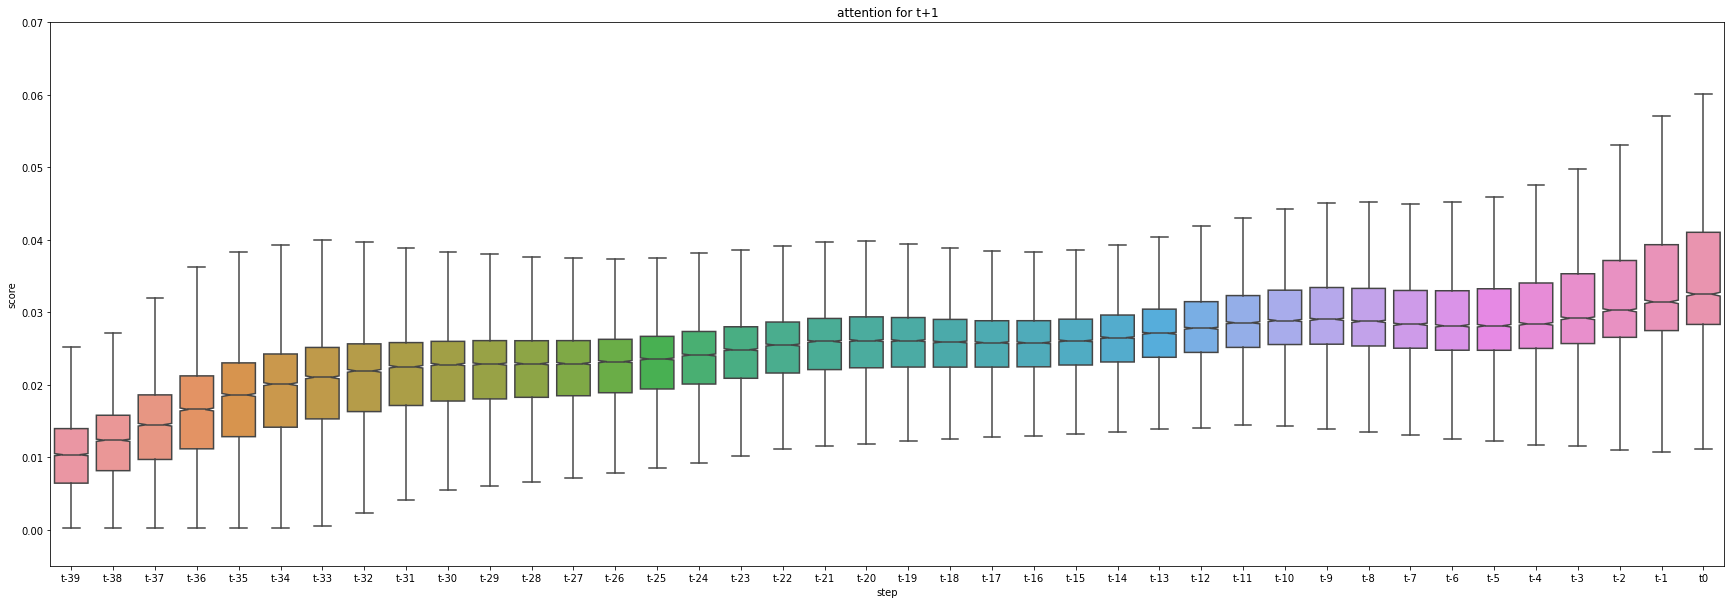

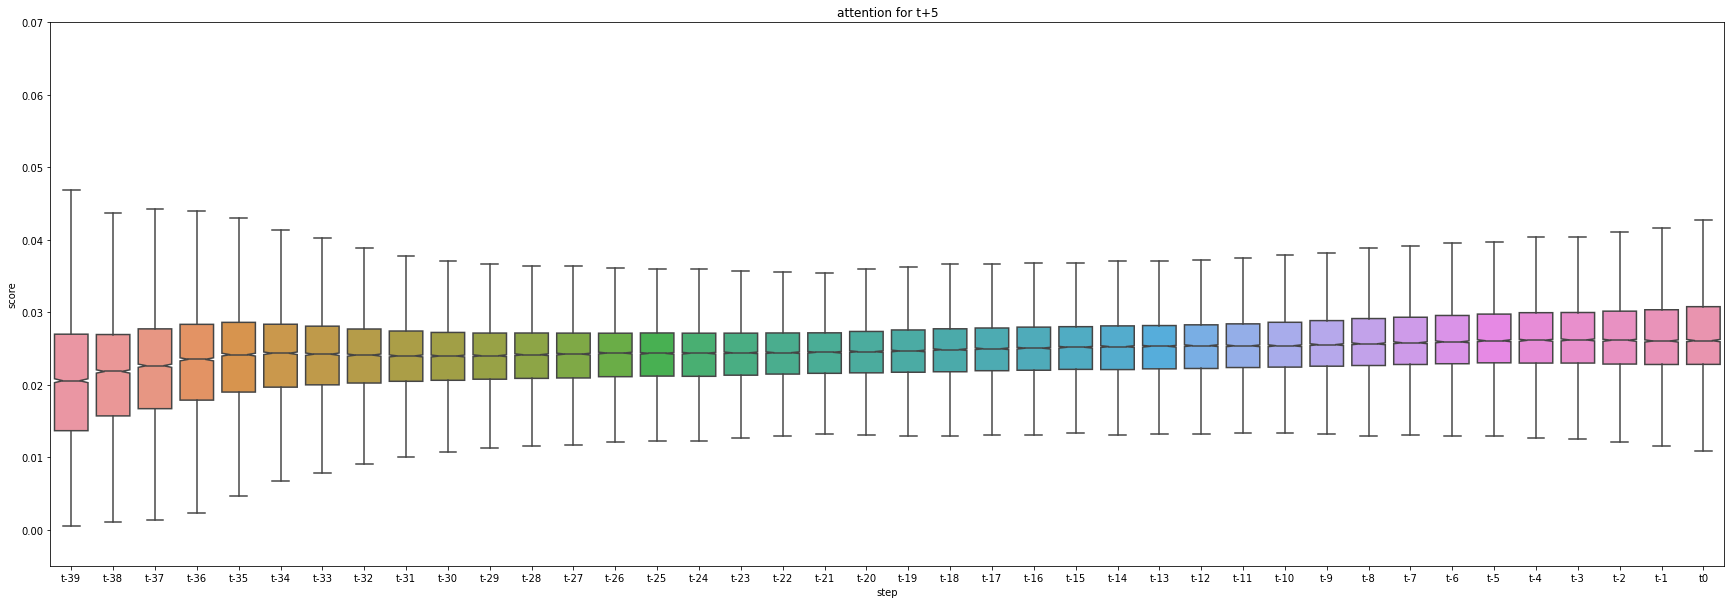

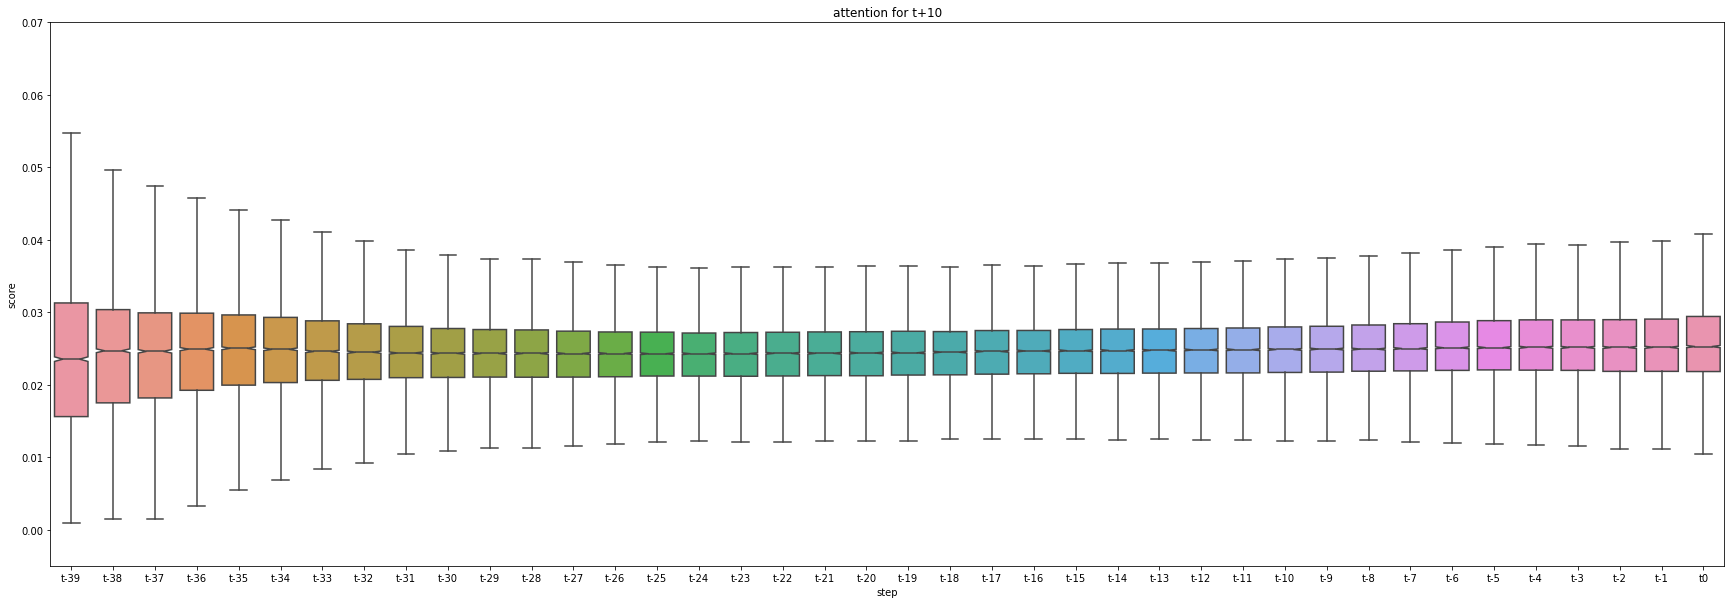

In [8]:
# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

model_num = 6
model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
DATT_seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
plot_steps = [0,4,9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    plt.ylim(-0.005, 0.07)
    plt.title(f"attention for t+{future_step+1}")
    savefile(_, './figure', f'AttentionScore_{model_name}', 'figure')
    plt.show()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 40, 20),     1740        ['input_2[0][0]']                
                                 (None, 20)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 10, 20)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 10, 20)       2520        ['repeat_vector_1[0][0]',  

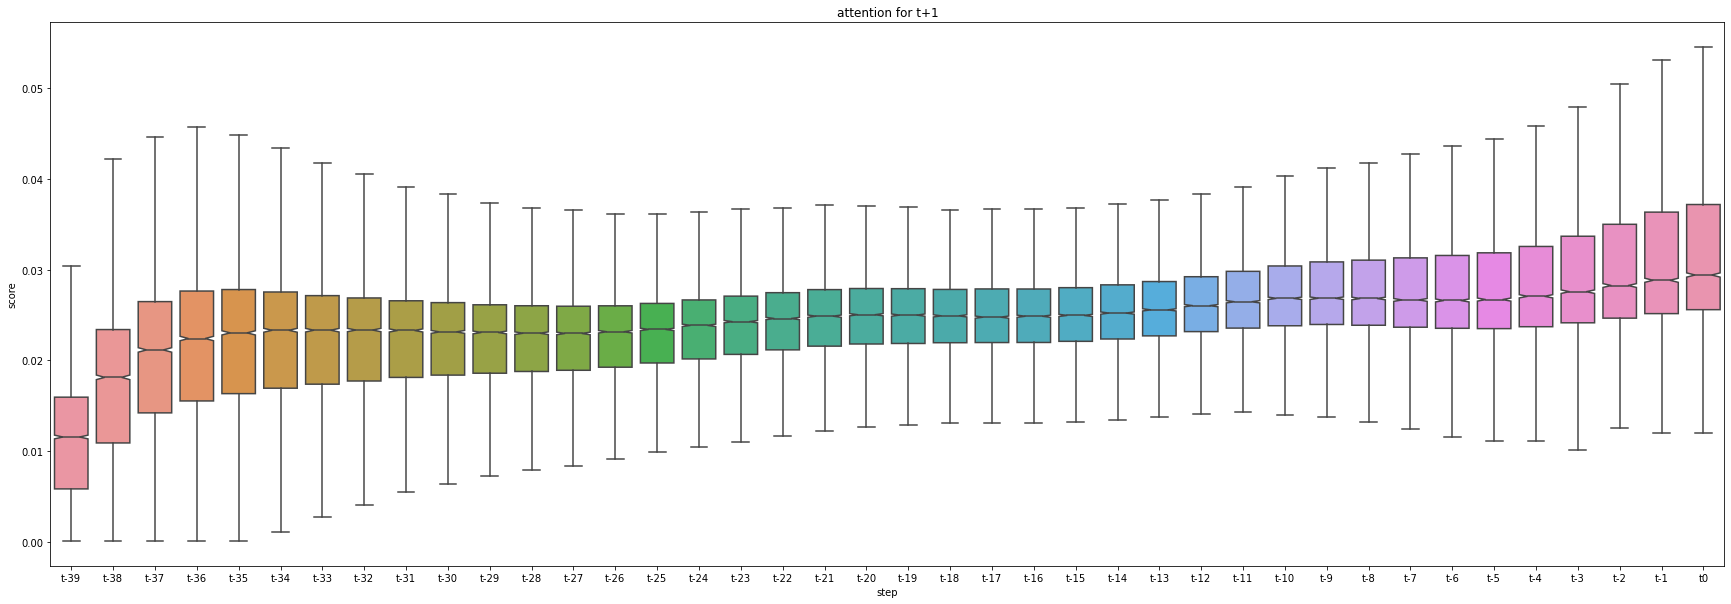

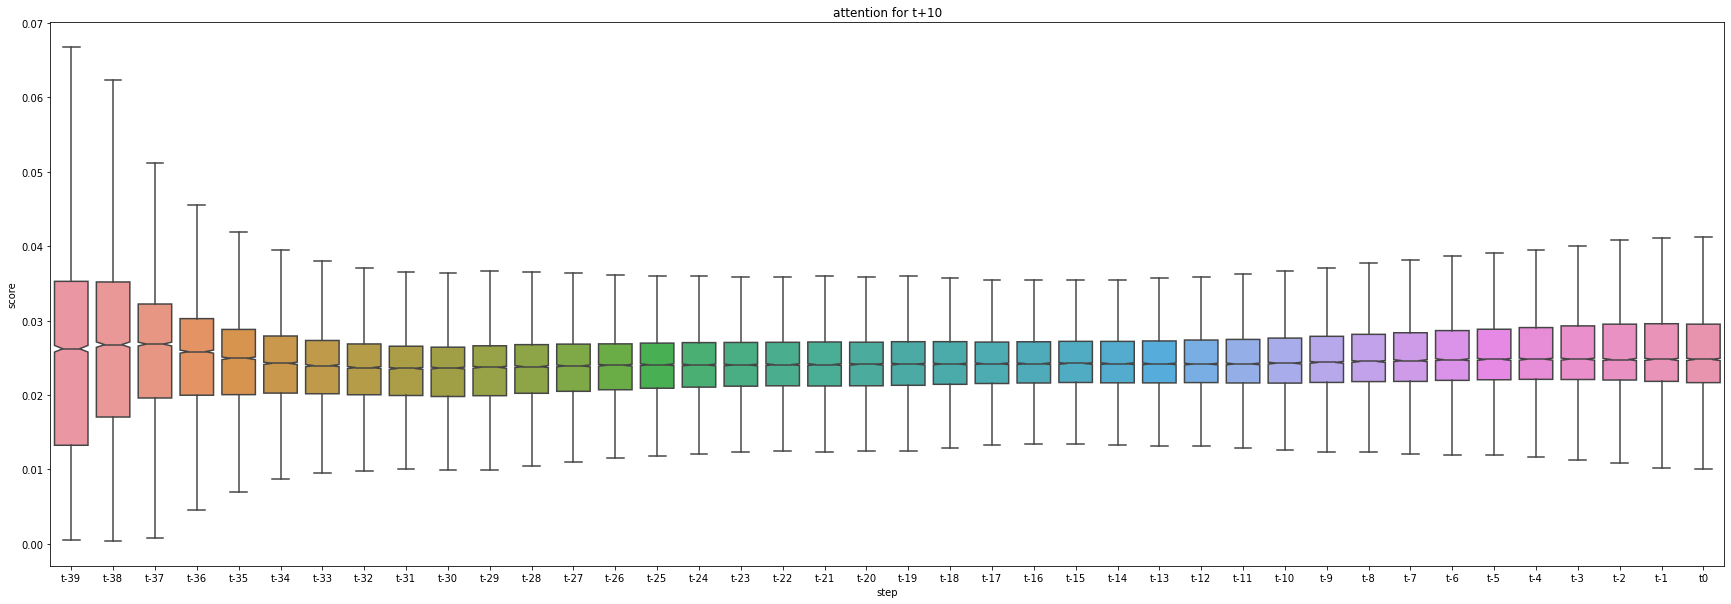

In [9]:
# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

model_num = 5
model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
DATT_seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
plot_steps = [0,9]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention for t+{future_step+1}")
    savefile(_, './figure', f'AttentionScore_{model_name}', 'figure')
    plt.show()

# Future = 20

In [11]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 20
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 0.5
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 100
dense_layers = 1
dense_neurons = 40
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,3)]
i=0
for iteration in iteration_list:
    for model_type in model_list: 
        model_num = iteration
        model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
        result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
        result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
        time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
        result = pd.concat([result, time_steps], axis=1)
        result['iteration'] = iteration
        result['num_layers'] = num_layers
        result['num_neurons'] = num_neurons
        result['dense_layers'] = dense_layers
        result['dense_neurons'] = dense_neurons        
        result['model_type'] = model_type
        if not i:
            result_reshape = result
        else:
            result_reshape = pd.concat([result_reshape, result], axis=0)
        i += 1

In [12]:
result_reshape[(result_reshape['step']=='mean')].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,num_layers,num_neurons,dense_layers,dense_neurons,model_type
20,0.394541,0.644681,0.695695,0.578306,12.276666,10.308986,8.295715,10.293789,mean,1,1,100,1,40,datt_seq2seq_gru
20,0.278796,0.624327,0.705464,0.536196,13.503758,10.575140,8.158425,10.745774,mean,2,1,100,1,40,att_seq2seq_gru
20,0.236476,0.667195,0.701211,0.534960,13.854144,9.938711,8.236703,10.676519,mean,2,1,100,1,40,datt_seq2seq_gru
20,0.225446,0.622141,0.720804,0.522797,14.020514,10.647930,7.999629,10.889358,mean,1,1,100,1,40,att_seq2seq_gru
20,0.112253,0.639578,0.634658,0.462163,14.906371,10.402573,9.068328,11.459091,mean,1,1,100,1,40,seq2seq_gru
20,0.126860,0.605219,0.607107,0.446395,14.805015,10.855938,9.460534,11.707162,mean,2,1,100,1,40,seq2seq_gru


## according to steps

R2 results


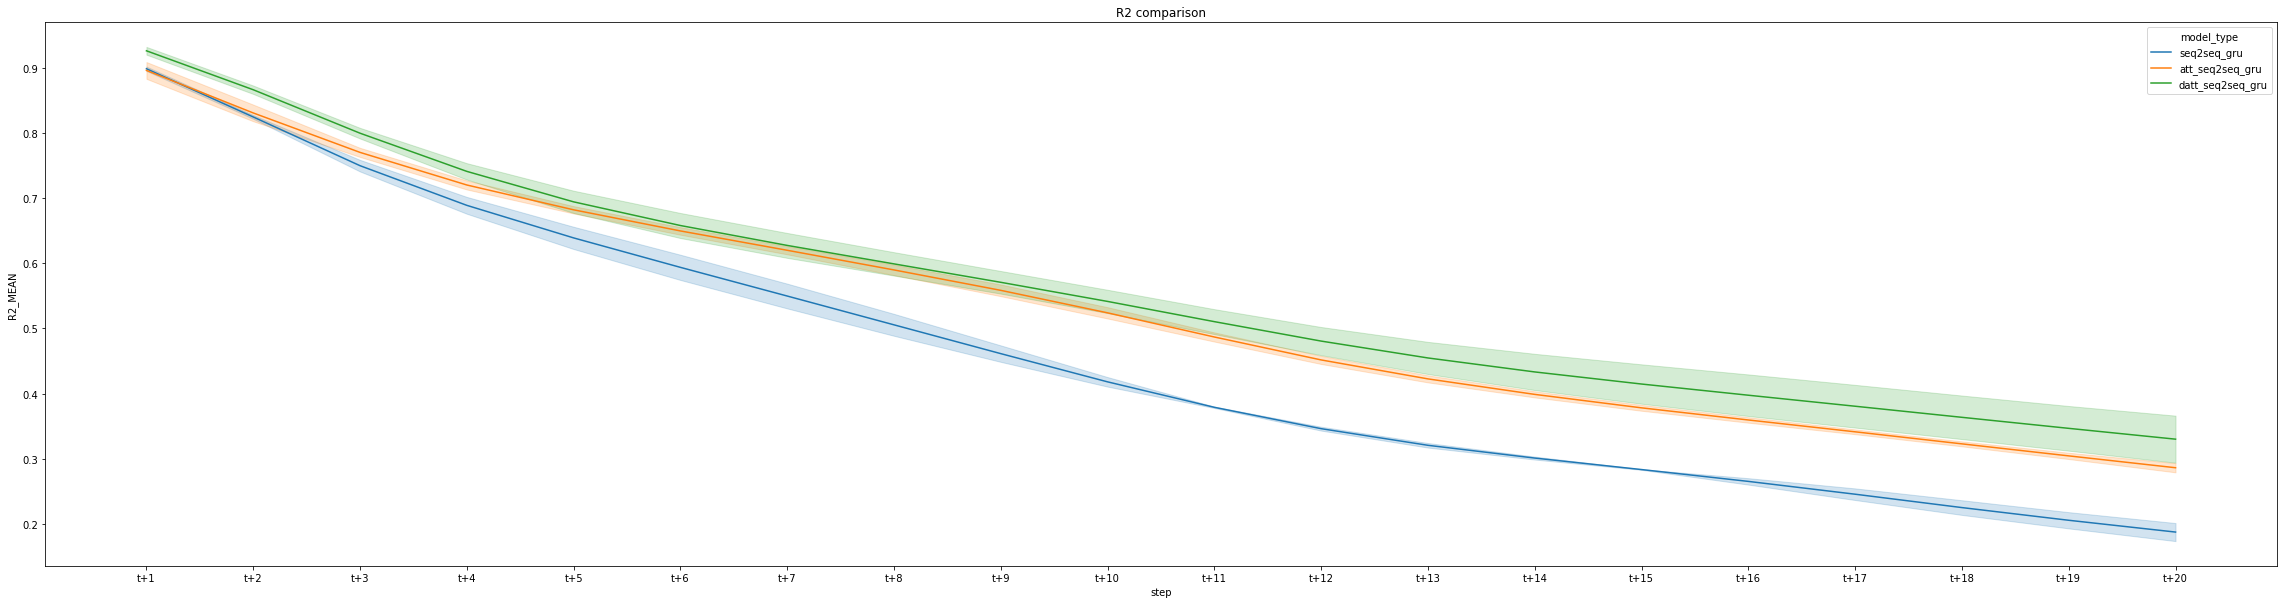

NRMSE results


<Figure size 432x288 with 0 Axes>

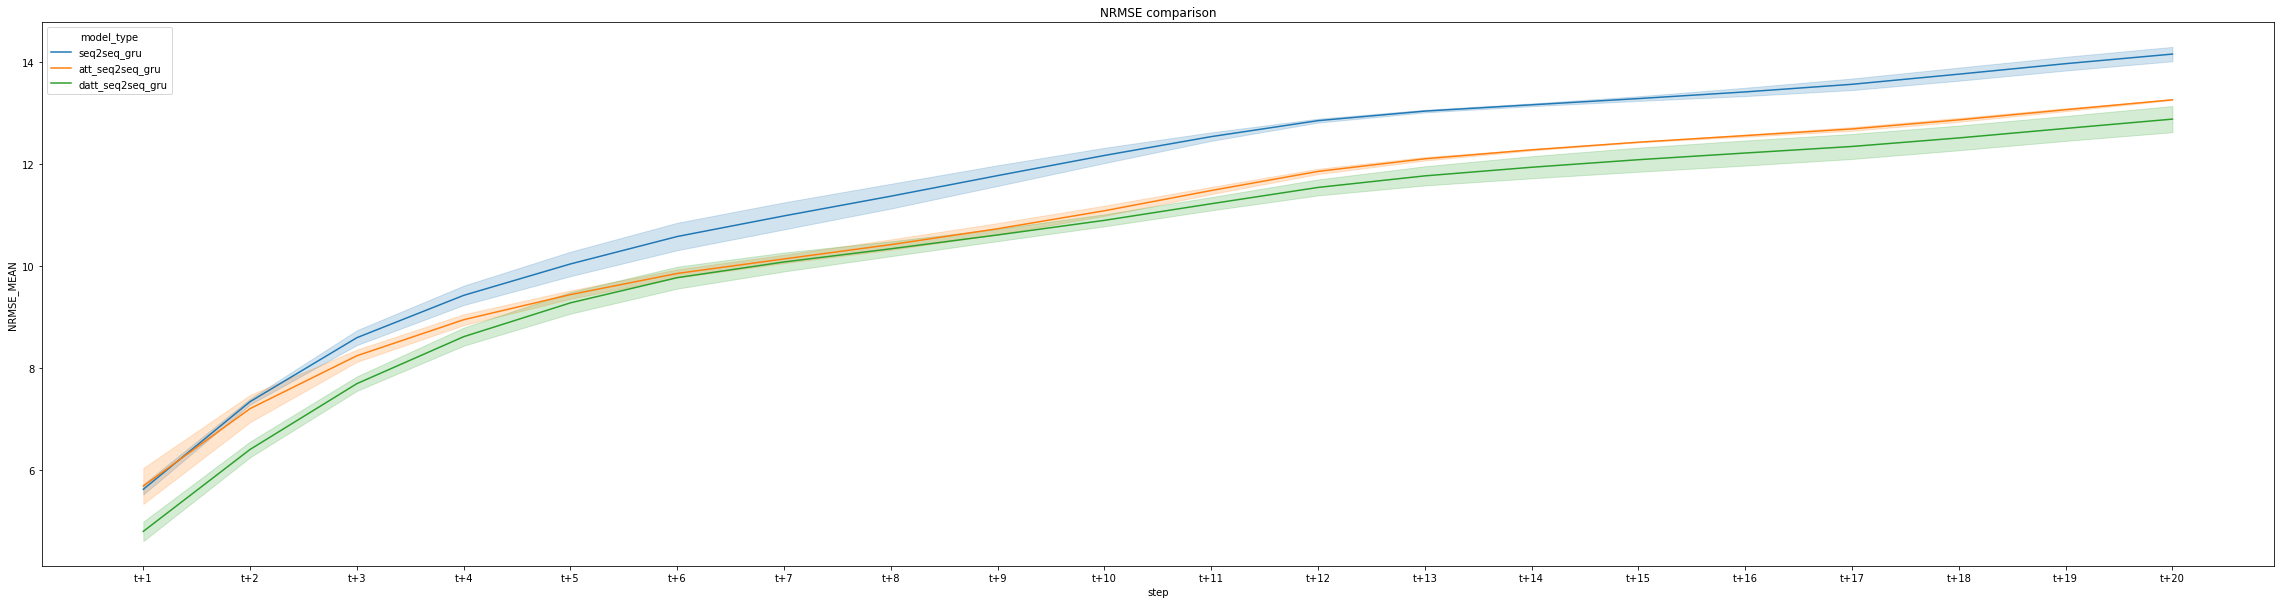

<Figure size 432x288 with 0 Axes>

In [14]:
data = result_reshape

plot_var = ['R2_MEAN']

print("R2 results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']!='mean'].reset_index(drop=True)
    sns.lineplot(x='step', y=var, hue='model_type', markers=True, data=plot_data)
    
    #plt.ylim(0.45, 1.0)
    plt.title(f"R2 comparison")
    
figure_name = f'figure_4_model_comparison_{model_name}_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()


plot_var = ['NRMSE_MEAN']

print("NRMSE results")
plt.figure(figsize=(future_size*2,len(plot_var)*10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']!='mean'].reset_index(drop=True)
    sns.lineplot(x='step', y=var, hue='model_type', markers=True, data=plot_data)
    
    # plt.ylim(0.45, 1.0)
    plt.title(f"NRMSE comparison")
    
figure_name = f'figure_4_model_comparison_{model_name}_nrmse'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

# data = result_reshape

# plot_var = ['NRMSE_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2']
# att_type = 'linear'

# print("NRMSE results")
# plt.figure(figsize=(future_size*2,len(plot_var)*10))
# for i, var in enumerate(plot_var):
#     plt.subplot(len(plot_var), 1, i+1)
#     plot_data = data[data['att_type']==att_type]
#     sns.boxplot(x='step', y=var, hue='delta', data=plot_data, notch=False, showfliers = False)
#     # plt.ylim(-0.01, 0.3)
#     plt.title(f"attention type = {att_type}")
    
# figure_name = f'delta_comparison_linear_future_{future_size}_nrmse'
# if not exists(f'./figure/{figure_name}.png') or update:
#     savefile(_, './figure', figure_name, 'figure')
    
# plt.show()
# plt.tight_layout()

## Dual attention

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 40, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 40, 100),    32700       ['input_6[0][0]']                
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_5 (RepeatVector)  (None, 20, 100)     0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 100)      60600       ['repeat_vector_5[0][0]', 

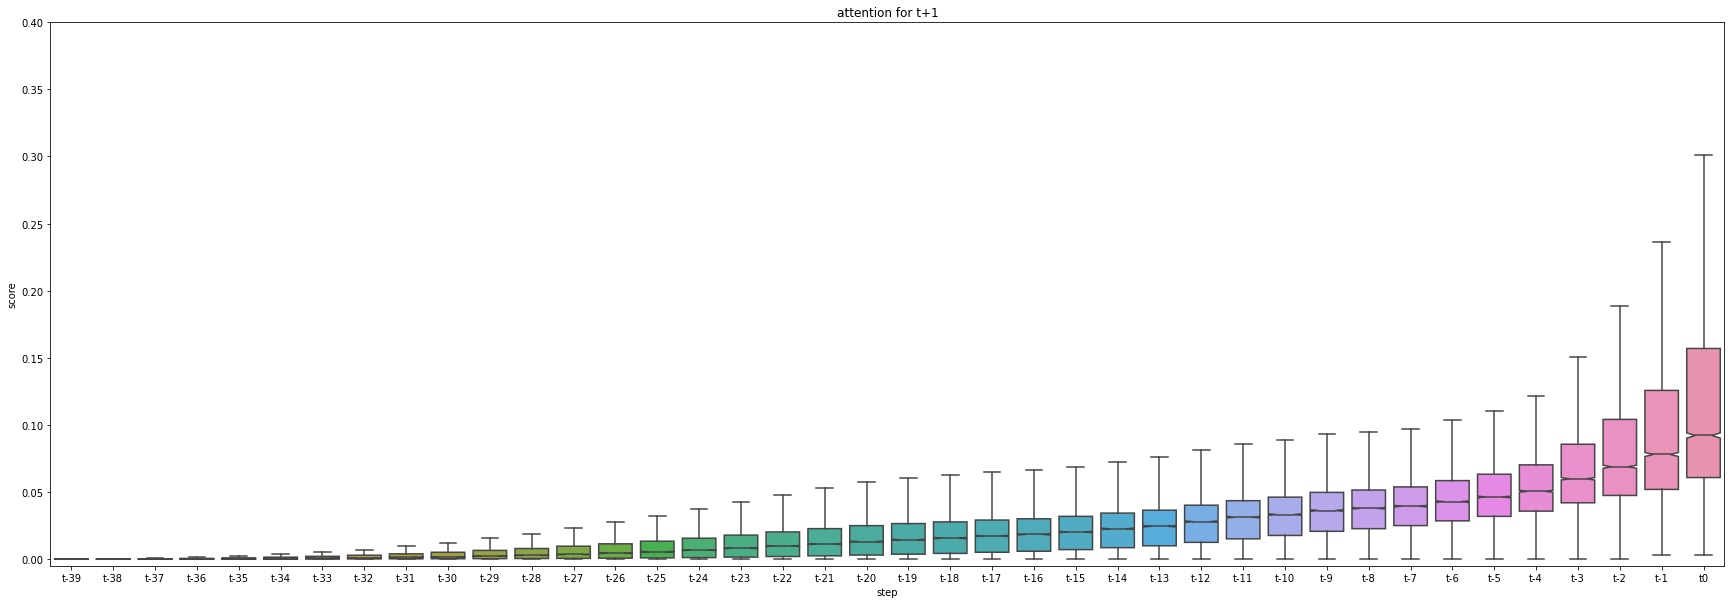

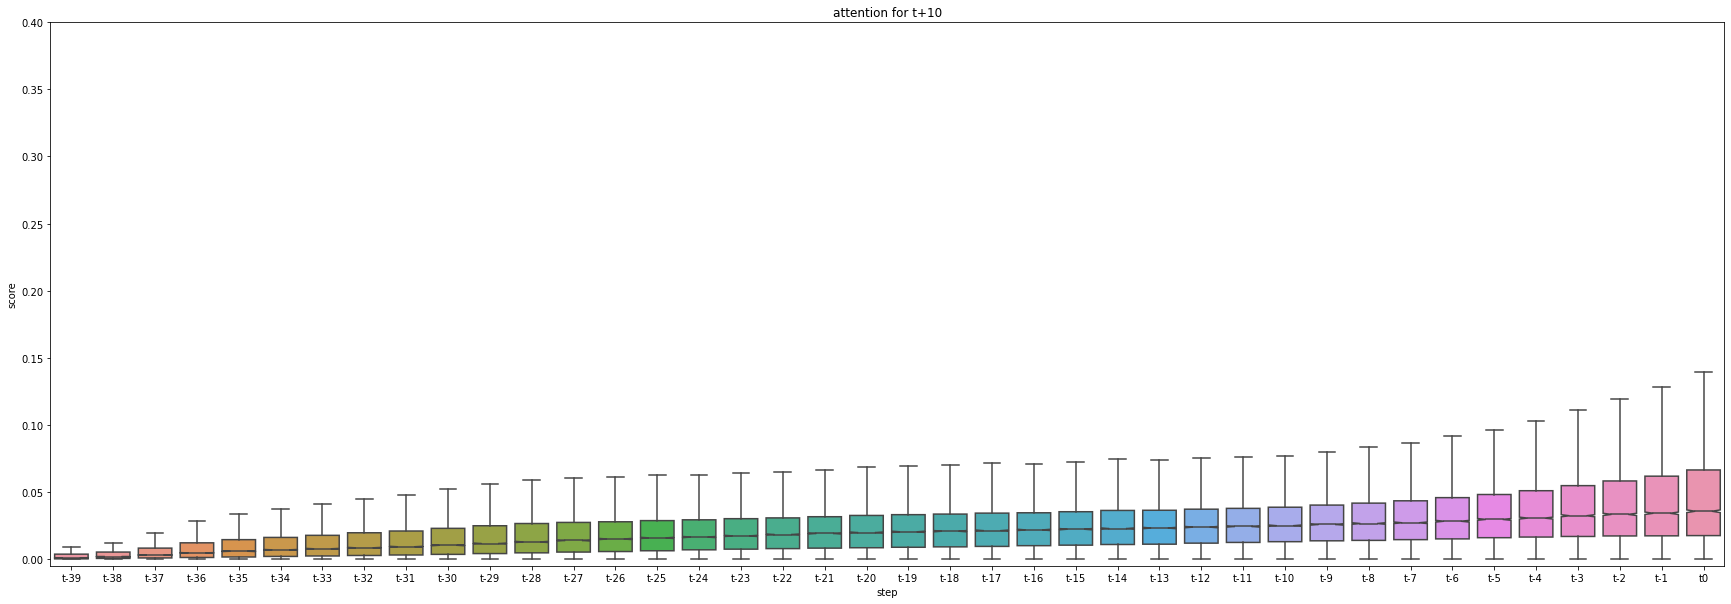

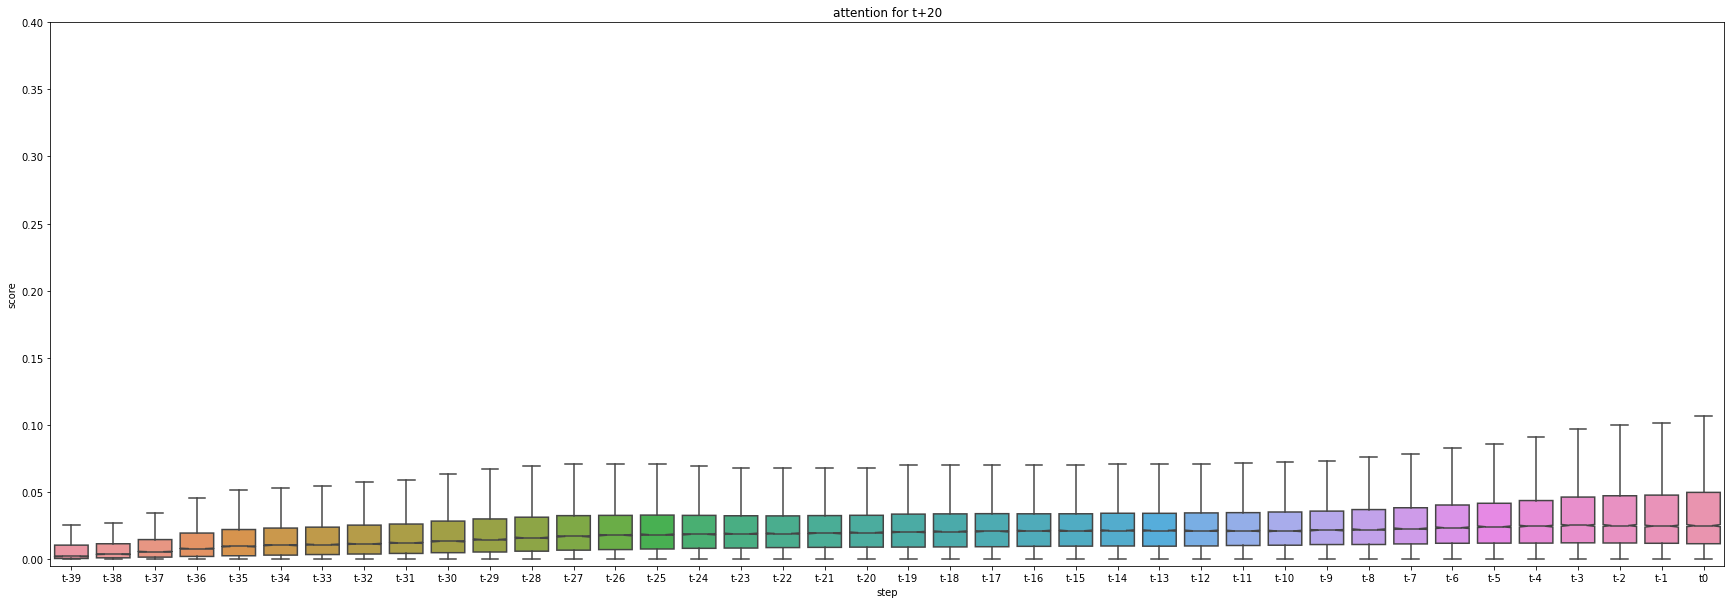

In [18]:
# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

model_num = 1
model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
DATT_seq2seq_GRU.model.load_weights(f"./model/{model_name}.h5")
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
plot_steps = [0,9,19]

for future_step in plot_steps:
    attention_step = pd.DataFrame(attention[:,future_step,:], columns=[f't{i-history_size+1}' for i in range(history_size)])

    for i in range(history_size):
        history_step = i-history_size+1
        if not i:
            attention_reshape = attention_step[[f't{history_step}']].copy()
            attention_reshape.columns = ['score']
            attention_reshape['step'] = f't{history_step}'
        else:
            temp = attention_step[[f't{history_step}']].copy()
            temp.columns = ['score']
            temp['step'] = f't{history_step}'        
            attention_reshape = pd.concat([attention_reshape, temp], axis=0)
        attention_reshape.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(30,10))
    sns.boxplot(x='step', y='score', data=attention_reshape, notch=True, showfliers = False)
    plt.ylim(-0.005, 0.4)
    plt.title(f"attention for t+{future_step+1}")
    savefile(_, './figure', f'AttentionScore_{model_name}', 'figure')
    plt.show()